In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.listdir('/kaggle/input/histopathologic-cancer-detection')

['train_labels.csv', 'train', 'test', 'sample_submission.csv']

In [16]:
os.listdir('/kaggle/input/histopathologic-cancer-detection/train')[0]

'98e0b957f30e872eb6d2d7c3f4987ac14c480242.tif'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from fastai import *
from fastai.vision import *

In [4]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


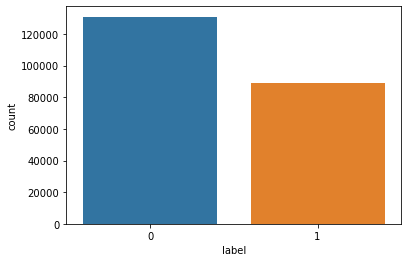

In [6]:
sns.countplot(x='label',data=labels)
plt.show()

A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image.

In [25]:
path=Path('/kaggle/input/histopathologic-cancer-detection/')
tfms = get_transforms(do_flip=True,flip_vert=True, max_warp=0, max_rotate=10, max_lighting=0.05)

In [26]:
path

PosixPath('/kaggle/input/histopathologic-cancer-detection')

In [47]:
data = ImageDataBunch.from_csv(path, 
                             csv_labels='train_labels.csv', 
                             folder='train', 
                             suffix='.tif',
                             num_workers=2,
                             ds_tfms=tfms,
                             bs=64,
                             size=72,
                             test=path/'test').normalize(imagenet_stats)

In [48]:
data.classes

[0, 1]

In [30]:
data.c

2

In [49]:
data

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72)
y: CategoryList
1,0,0,0,0
Path: /kaggle/input/histopathologic-cancer-detection;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72)
y: CategoryList
0,0,0,1,0
Path: /kaggle/input/histopathologic-cancer-detection;

Test: LabelList (57458 items)
x: ImageList
Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72),Image (3, 72, 72)
y: EmptyLabelList
,,,,
Path: /kaggle/input/histopathologic-cancer-detection

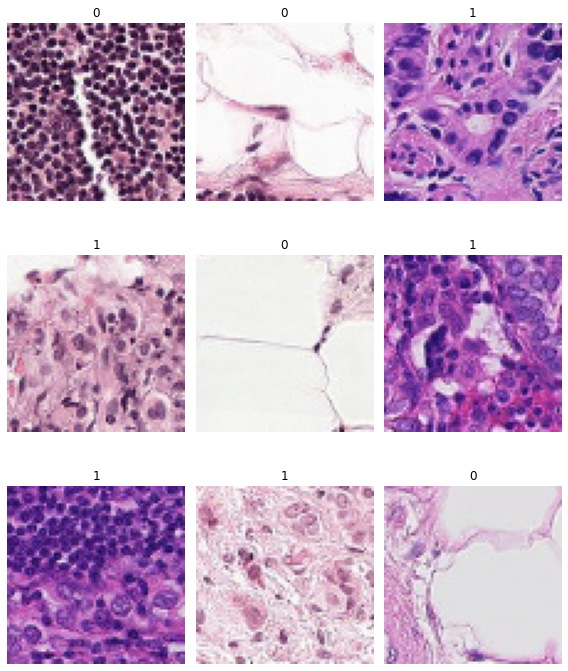

In [50]:
data.show_batch(rows=3,figsize=(8,10))

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [59]:
learn= create_cnn(data, models.resnet34, metrics=[accuracy],model_dir='/kaggle/working/')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


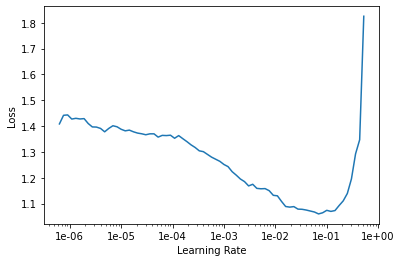

In [60]:
learn.lr_find()
learn.recorder.plot()

In [62]:
#wd = weight decay
learn.fit_one_cycle(6, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4, 1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.330801,0.279929,0.887467,09:49
1,0.270727,0.238480,0.907851,07:48
2,0.252128,0.208996,0.917896,07:25
3,0.227571,0.199616,0.922736,07:17
4,0.201449,0.194507,0.924304,07:19
5,0.219230,0.187398,0.926599,07:20


Unfreeze the layers- weights of all the fozen layers will be updated

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


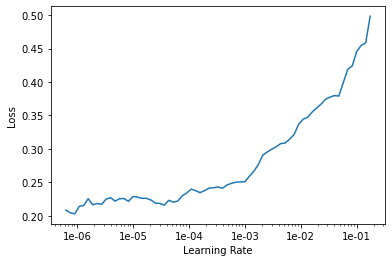

In [64]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(15, slice(1e-5,1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.211722,0.178763,0.930962,08:16
1,0.202532,0.187590,0.925736,08:11
2,0.186252,0.162517,0.938552,07:49
3,0.165113,0.144459,0.946120,07:38
4,0.144861,0.132601,0.950824,07:40
5,0.140174,0.123766,0.954437,07:36
6,0.115876,0.117828,0.957959,07:37
7,0.115181,0.112238,0.959800,07:38
8,0.120029,0.105952,0.961209,07:38
9,0.097650,0.097183,0.964981,07:44


In [67]:
learn.save('stage-1') 

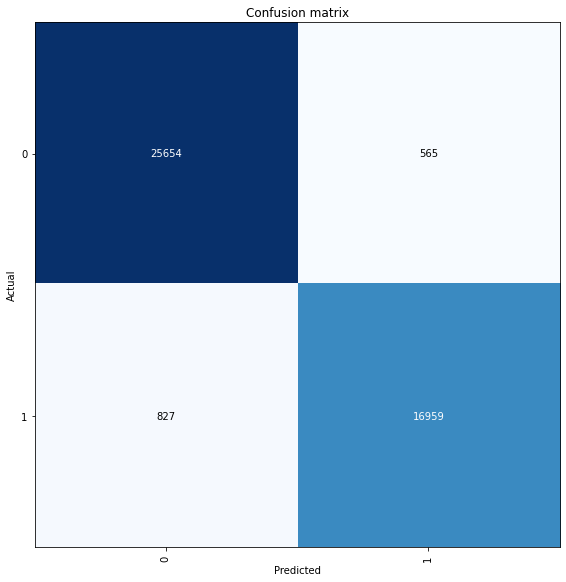

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

**Validation Accuracy**

In [72]:
preds,y = learn.get_preds(DatasetType.Valid)

**Accuracy**

In [73]:
accuracy(preds,y)

tensor(0.9684)

**Predictions on the Test Data**

In [74]:
label,y=learn.get_preds(DatasetType.Test)

In [76]:
sub = pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [77]:
data.test_ds.items[0]

PosixPath('/kaggle/input/histopathologic-cancer-detection/test/7eacfa39f006b4a81d5772e3bf0cf866beae5960.tif')

In [81]:
names=np.vectorize(lambda img_name: str(img_name).split('/')[-1][:-4]) 


In [82]:
file_names= names(data.test_ds.items).astype(str)

In [79]:
label.numpy()[:,1]

array([7.843031e-01, 2.369606e-04, 7.960448e-02, 9.890576e-01, ..., 5.618435e-06, 1.213569e-05, 2.122231e-07,
       9.982536e-01], dtype=float32)

In [83]:
sub.loc[file_names,'label']=label.numpy()[:,1]
sub.to_csv(f'submission_resnet34.csv')

In [84]:
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.001650
95596b92e5066c5c52466c90b69ff089b39f2737,0.003965
248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000045
2c35657e312966e9294eac6841726ff3a748febf,0.002906
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.016618


In [85]:
predictions = []
for i in label:
    predictions.append(i.argmax().item())

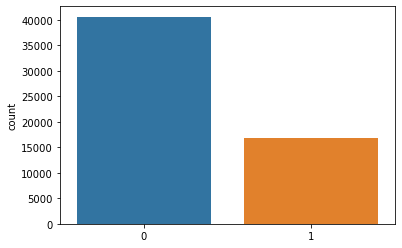

In [86]:
sns.countplot(predictions)

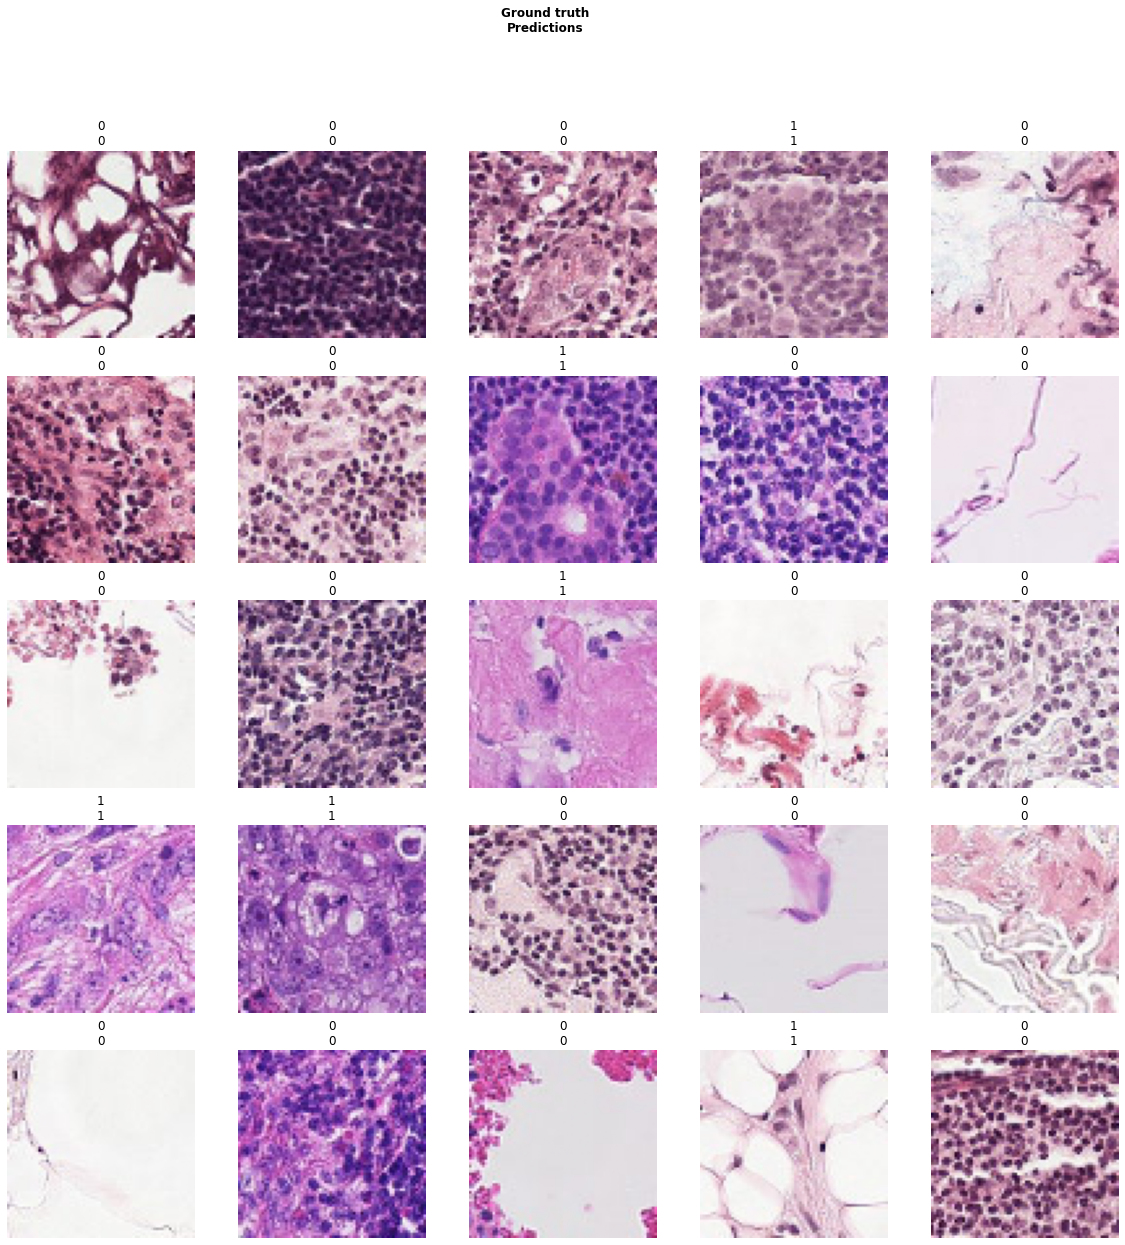

In [87]:
learn.show_results()

**Visualize Predictions made by the resnet34 Model**

In [ ]:
_,axs = plt.subplots(3,5,figsize=(11,8))
for i,ax in enumerate(axs.flatten()): 
  img = data.test_ds[i][0]
  img.show(ax=ax,y=learn.predict(img)[0])